In [1]:
using Graphs
using Bloqade
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

In [2]:
graph_1 = [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (1, 3), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (3, 5), (3, 6), (4, 7), (5, 6), (5, 7), (6, 7)];
graph_1

18-element Vector{Tuple{Int64, Int64}}:
 (0, 1)
 (0, 2)
 (0, 3)
 (0, 5)
 (0, 6)
 (0, 7)
 (1, 3)
 (1, 5)
 (1, 6)
 (1, 7)
 (2, 3)
 (2, 4)
 (3, 5)
 (3, 6)
 (4, 7)
 (5, 6)
 (5, 7)
 (6, 7)

In [3]:
atom_list = [(2.0,2.0),(3.0,0.0),(0.0,9.0),(0.5,1.6),(7.0, 9.0),(3.0, 2.0),(6.0, 0.0),(8.0, 5.0)]

8-element Vector{Tuple{Float64, Float64}}:
 (2.0, 2.0)
 (3.0, 0.0)
 (0.0, 9.0)
 (0.5, 1.6)
 (7.0, 9.0)
 (3.0, 2.0)
 (6.0, 0.0)
 (8.0, 5.0)

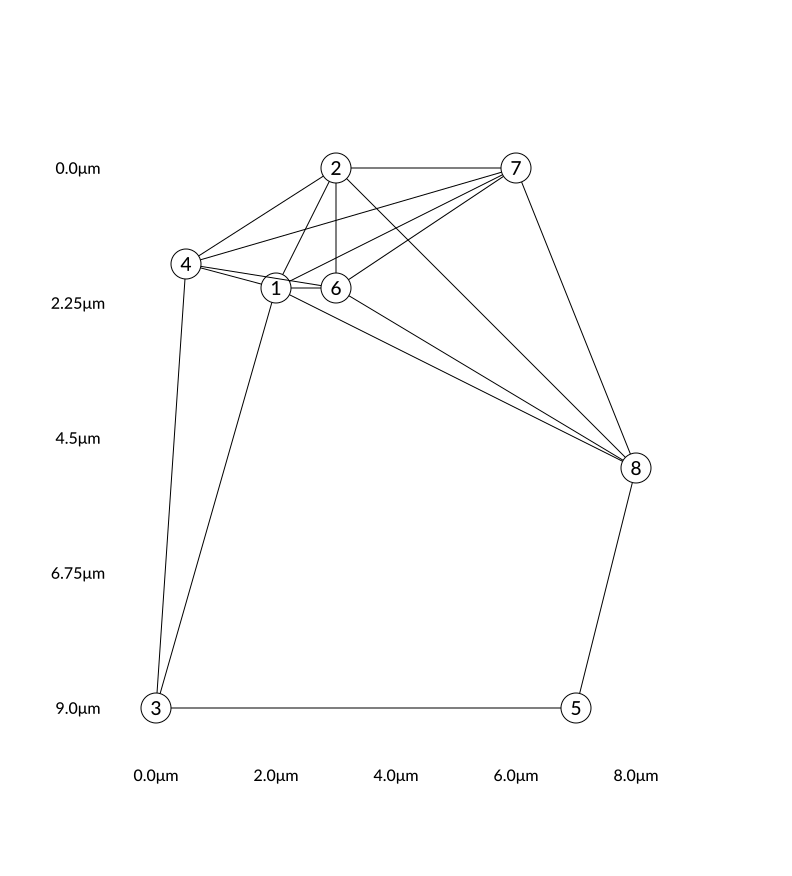

In [4]:
atoms= AtomList(atom_list)
Bloqade.plot(atoms, blockade_radius = 7.5)

In [5]:

# Our goal is to find a maximum independent set of such a graph.

# For comparison, we first use classical algorithms to calculate the MIS size here using the graph utilities in Bloqade, 
# so that one can compare this exact result with the quantum algorithms.
# The exact MIS size and its degeneracy can be solved with the generic tensor network algorithm in the package [`GenericTensorNetworks`](https://github.com/QuEraComputing/GenericTensorNetworks.jl):
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

# The `solve` function takes a graph instance and a solution space property as inputs,
# where the graph instance is generated by the [`unit_disk_graph`](@ref) function in the module `BloqadeMIS`,
# and the solution space property is to count the number of maximum independent sets here.
# For this specific DUGG, we see that the MIS size is 4, and the number of maximum independent sets is 26.
# In the following, we are going to show how to solve the independent set problem with both quantum adiabatic and variational algorithms.


(2.0, 10.0)ₜ

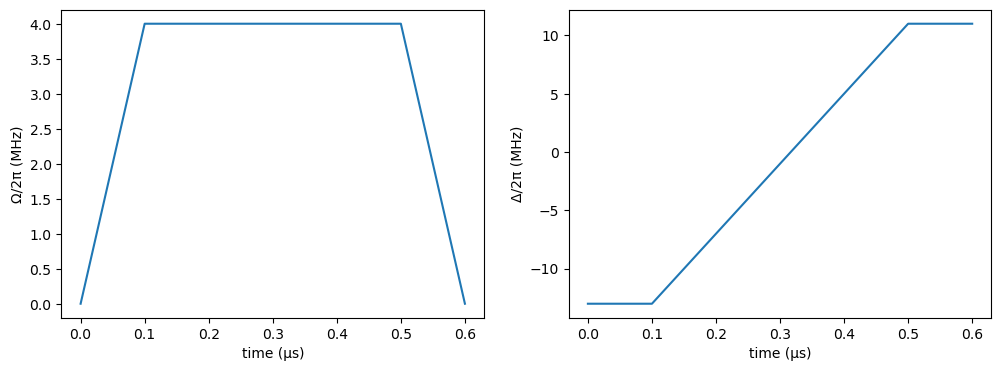

In [6]:
# ## The Adiabatic Approach

# Here, we generalize the quantum adiabatic algorithm used in 
# the tutorial [Adiabatic Evolution](@ref) to prepare ground states of the Rydberg Hamiltonian for this disordered lattice.
# We first construct the adiabatic pulse sequences for the Rabi frequency ``\Omega`` and the detuning ``\Delta``:

T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig


In [7]:
# Here, the total time is fixed to `T_max`, the adiabatic evolution path is specified by the [`piecewise_linear`](@ref) function.
# Rydberg blockade radius can be computed with 
# ```math
# C_6 / R_b^6 \sim \sqrt{\Delta^2 + \Omega^2}
# ```
# The default ``C_6=2π * 862690 \text{ MHz μm}^6``.
# For encoding the corresponding MIS problem at ``\Omega = 0``, 
# the detuning can be set around ``2\pi \times 11`` MHz 
# for a blockade radius of ``7.5`` µm
# (see the parameters in [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372)).

# Next, we create the time-dependent Hamiltonian and simulate its time evolution by using the [`SchrodingerProblem`](@ref) solver:

hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://diffeq.sciml.ai/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/toto/.julia/packages/SciMLBase/TqBga/src/integrator_interface.jl:413


SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 34.023 KiB
    expression:
nqubits: 8
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


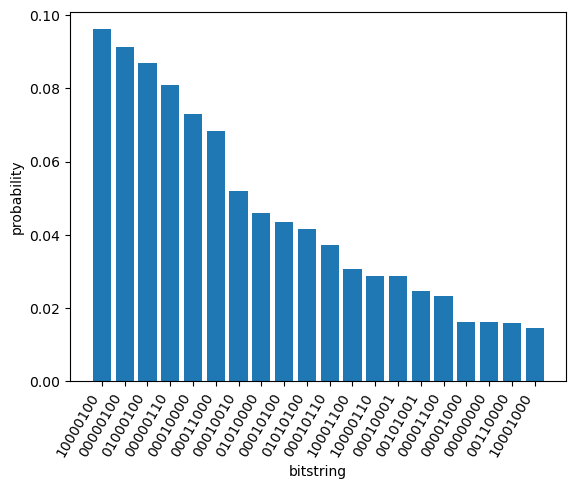

In [8]:
# Finally, we can plot the most probable bitstrings by using the [`bitstring_hist`](@ref) function on the resulting register (quantum state):
bitstring_hist(prob.reg; nlargest = 20)

In [9]:
# We can see that some of the most probable configurations indeed have an independent set size 4 by counting the number of ones in the bitstring.
# The correctness of the output can be verified by comparing it to the classical solution:

best_bit_strings = most_probable(prob.reg, 5)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]


(2.0, {00011000, 00100001, 00010001, 00001100, 00100100, 01001000, 01100000, 10001000, 00001010, 00100010})ₜ

In [10]:
@assert all(bs -> GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c, best_bit_strings)

LoadError: AssertionError: all((bs->begin
            #= In[10]:1 =#
            GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c
        end), best_bit_strings)

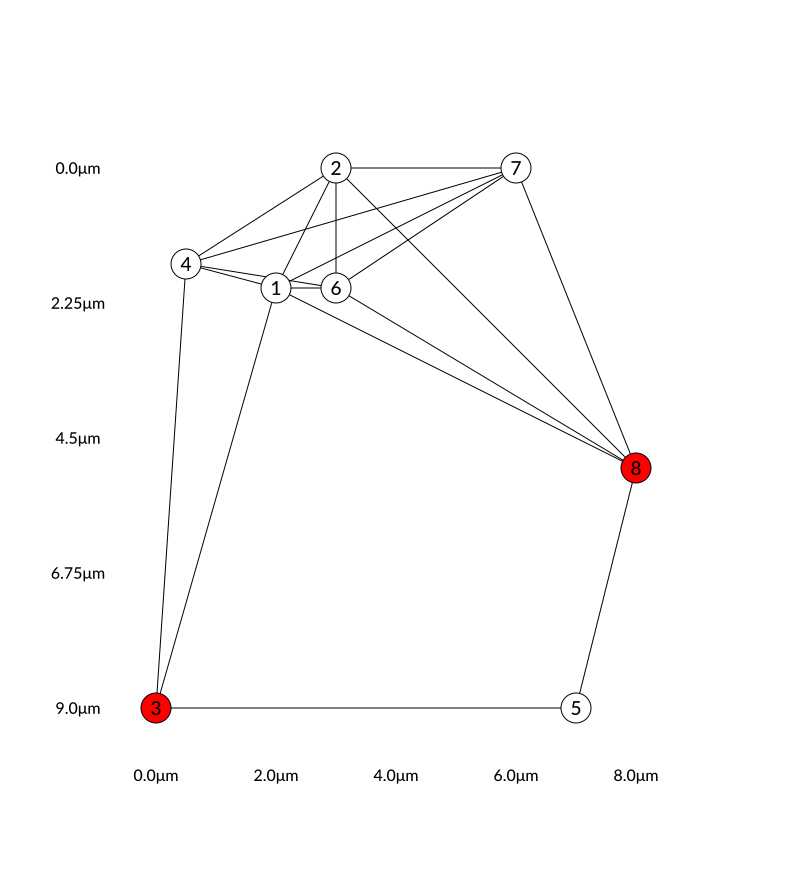

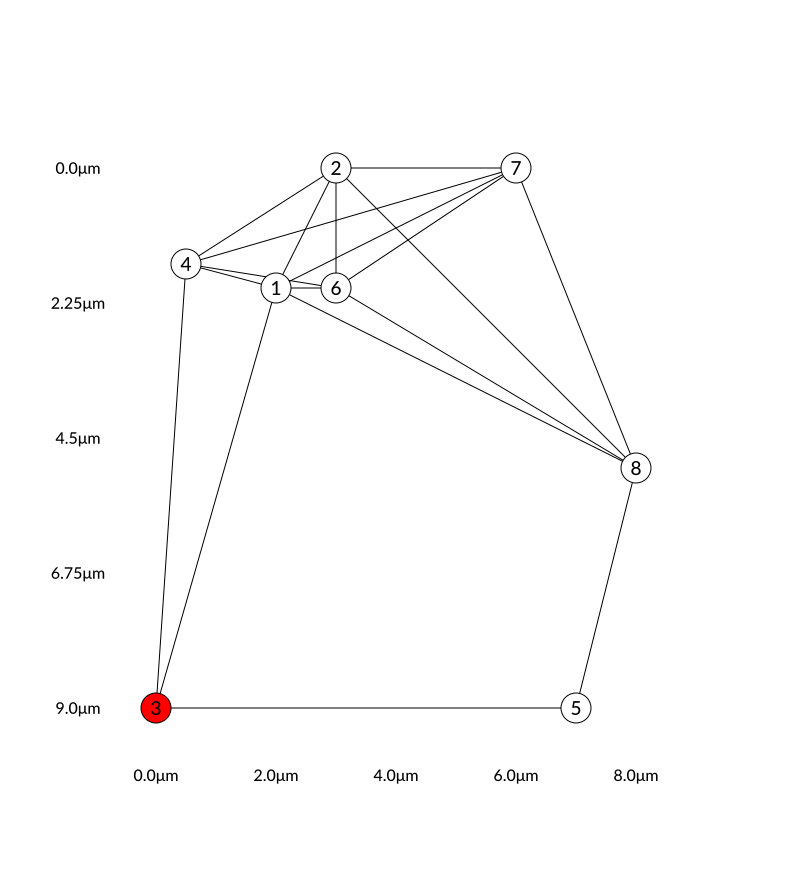

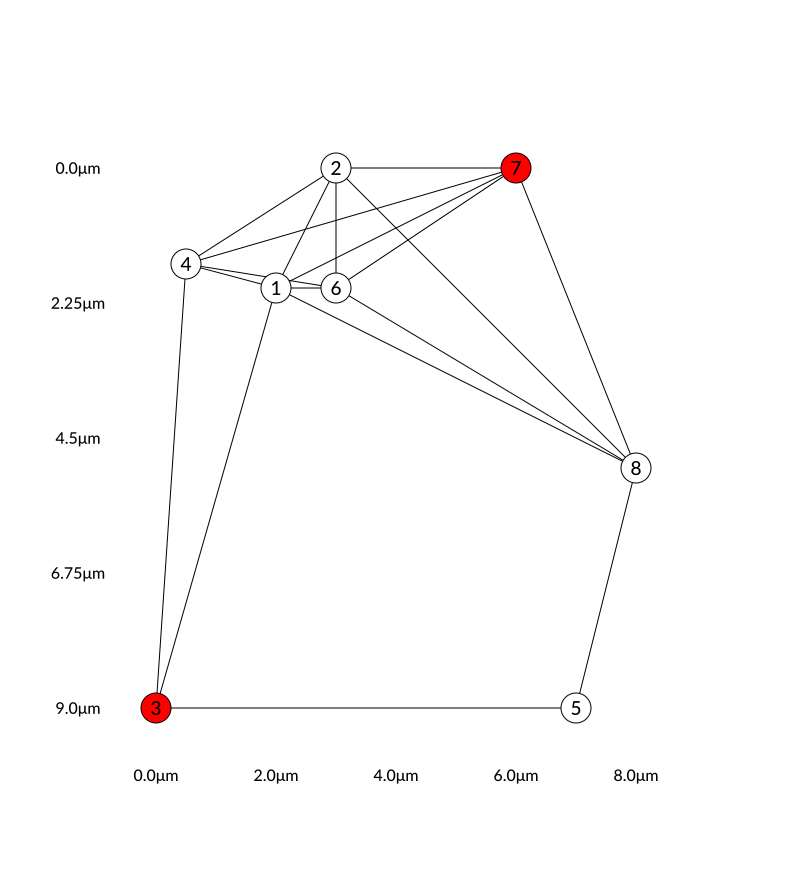

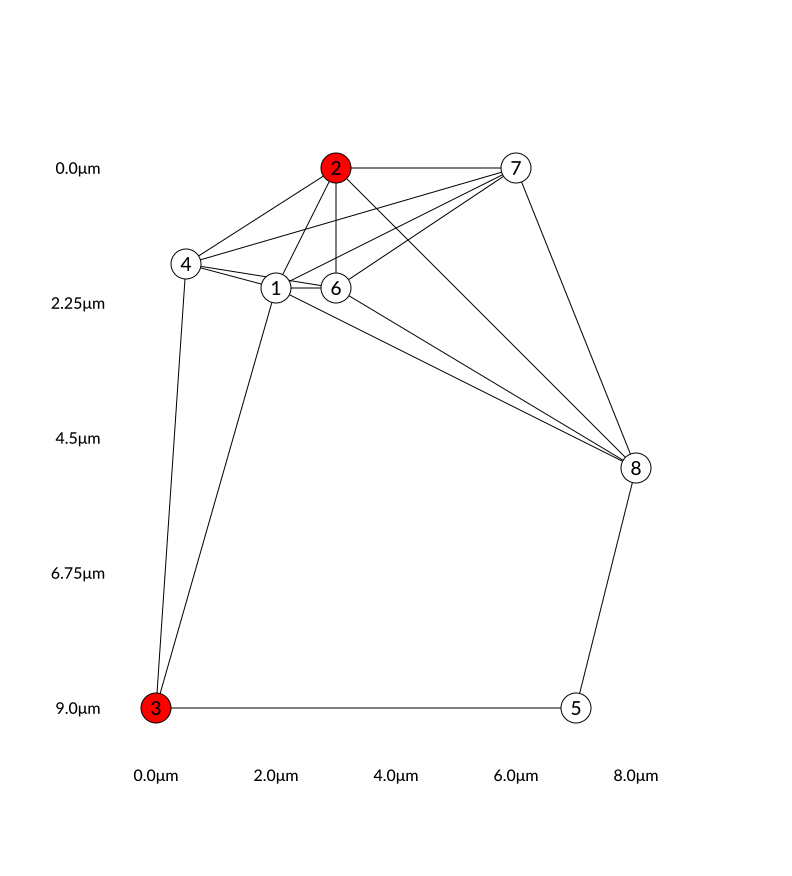

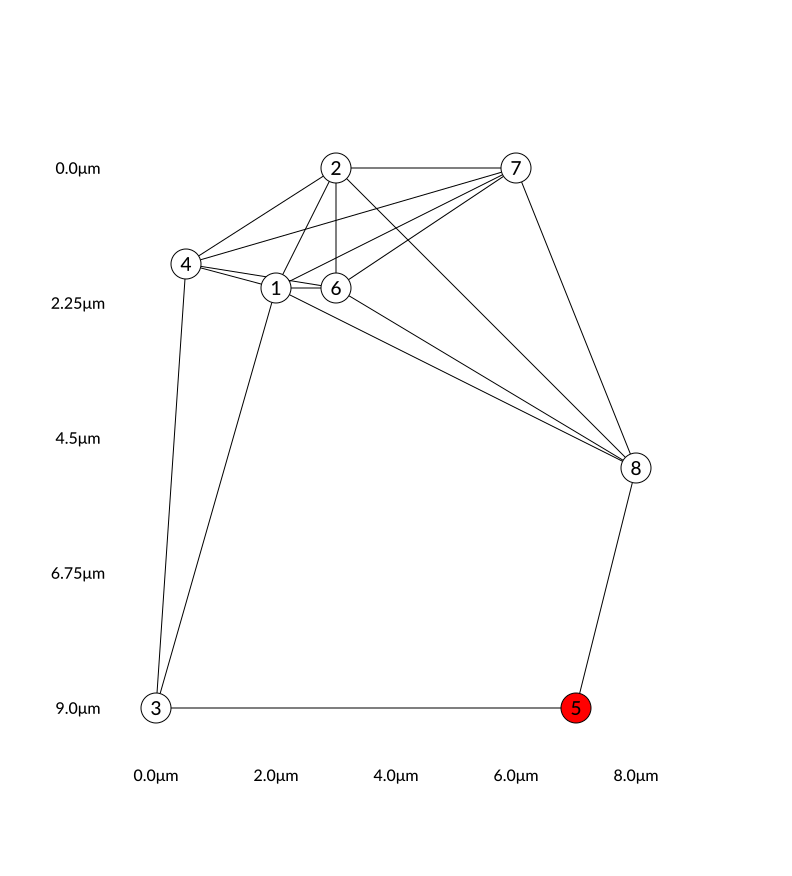

LoadError: BoundsError: attempt to access 5-element Vector{DitStr{2, 8, Int64}} at index [6]

In [11]:
for index in 1:6
    display(Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[index]]))
end

In [12]:
# However, there are still some configurations that violate the blockade constraint, 
# because the blockade interaction is not an ideal unit disk constraint (e.g. some bitstrings have a size 5).
# One can check whether the independence constraint is satisfied or not with the [`BloqadeMIS.is_independent_set`](@ref) function:
best5_bit_strings = most_probable(prob.reg, 3)
BloqadeMIS.is_independent_set.(best5_bit_strings, Ref(graph))


3-element BitVector:
 1
 1
 1

In [13]:

# This can happen when the Rydberg interaction is not very strong at the unit disk radius.
# See the [Rydberg Blockade](@ref blockade) page for more detailed explanations on Rydberg blockade 
# and its relation with the unit disk radius.
# One can perform some postprocessing by reducing the violated configurations to indendendent set configurations 
# using the [`mis_postprocessing`](@ref) function. See the function documentation for more details on what it does. 
# Please also refer to the paper [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372) 
# for more detailed discussion on the postprocessing procedure.
fixed = mis_postprocessing(best5_bit_strings[3], graph)
BloqadeMIS.is_independent_set(fixed, graph)


true

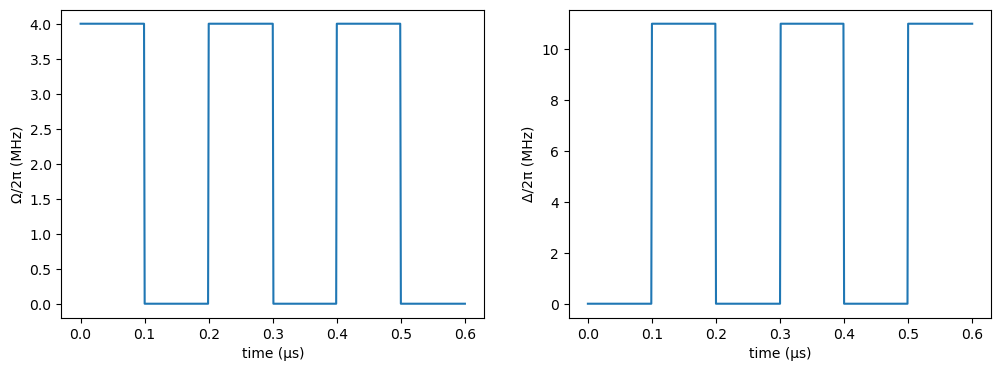

In [14]:

# ## QAOA with Piecewise Constant Pulses
# The QAOA algorithm ([arxiv:1411.4028](https://arxiv.org/abs/1411.4028)) is a hybrid quantum-classical algorithm. 
# The classical part of the algorithm is an optimizer, which can be either a gradient-based or non-gradient-based one.
# For our specific problem, the corresponding quantum part is a neutral-atom quantum computer 
# first evolving under the Rydberg Hamiltonian with parameterized pulse sequences and then being measured in the computational basis.

# The standard definition of QAOA involves applying the problem (cost function) Hamiltonian ``C`` and the transverse field Hamiltonian ``B`` alternately.
# Let ``G=(V,E)`` be a graph. The cost Hamiltonian for an MIS problem can be defined as 
# ```math
# C(G) = -\sum_{j\in V}^{n} w_j n_j^z + \infty \sum_{\langle j,k\rangle \in E}n_j^z n_k^z
# ```
# where the first summation is proportional to the size of the independent set, 
# and the second term enforces the independence constraints.

# In a Rydberg Hamiltonian, the first term corresponds to the detuning ``w_i = \Delta``.
# The second term contains an ``\infty``, which corresponds to the Rydberg blockade term 
# with its strength described as ``V_{jk} = C_6/|\overrightarrow{\mathbf{r_j}} - \overrightarrow{\mathbf{r_k}}|^6``.
# As we can see, the Rydberg interaction is not a perfect independence constraint (with finite blockade interaction and unwanted long-rance interaction). 
# Thus, postprocessing might be required using neutral-atom quantum computers to solve the MIS problem.
#
# The transverse field Hamiltonian corresponds to the Rabi term in the Rydberg Hamiltonian,
# ```math
# B = \sum_{j=1}^{n}\sigma_j^x + \infty \sum_{\langle j,k\rangle \in E}n_j^z n_k^z.
# ```

# Note that the Rybderg interaction term is always on here 
# in contrast to the standard QAOA protocol. 
# For the convenience of the simulation, we use the [`expect`](@ref) function to get the averaged measurement outputs. 
# On the actual quantum hardware, the `expect` should be replaced by measuring in the computational basis
# and obtaining the averaged number of Rydberg excitations as the loss function (also called objective function or cost function).
# One can then either use non-gradient-based optimizers to perform the optimization 
# or use finite-difference methods to obtain gradients of parameters.

# Let us first set up a non-optimized pulse sequences for QAOA with step ``p=3``:

durations = fill(0.1, 6)
clocks = [0, cumsum(durations)...]
Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 3))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 3))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [15]:
# The `piecewise_constant` pulses can be more accurately simulated with the [`KrylovEvolution`](@ref) solver.
# This time, we simulate the dynamics in the subspace generated by the [`blockade_subspace`](@ref) function, so that we do not need postprocessing anymore.
hamiltonian2 = rydberg_h(atoms; Ω = Ω2, Δ = Δ2)
nsites = length(atoms)
subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace 
prob2 = KrylovEvolution(zero_state(subspace), clocks, hamiltonian2)
emulate!(prob2);

In [16]:
# We defined the loss function as the negative of the mean MIS size, 
# which corresponds to the expectation value of the [`SumOfN`](@ref) operator.
# Thus, we can calculate the 

# average loss function after the time evolution:  
loss_MIS(reg) = -rydberg_density_sum(prob2.reg)
loss_MIS(prob2.reg)

-1.1268284094692447

In [17]:
# The ouput shows the negative mean independent set size. 
# This is because we have flipped its sign since most optimizers are set to minimize the loss function.
# This loss is equivalent to the [`rydberg_density_sum`](@ref) loss function in the [`BloqadeMIS`](@ref) module. 
# Alternative loss functions include the [`gibbs_loss`](@ref) and the [`independent_set_probabilities`](@ref).

# Here, the loss produced by these pulse sequences does not look very good.
# We can throw it into an optimizer and see if a classical optimizer can help.
# First, let us wrap up the above code into a loss function:

function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 4 * 2π
    Δ_end = 11 * 2π
    p = length(x) ÷ 2

    ## detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input 
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace 
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end

loss_piecewise_constant (generic function with 1 method)

In [18]:
# !!! note
#     Running the simulation in the subspace does not violate the independence constraints.
#     If one uses fullspace simulation or runs it on the quantum computer, one may need to post-process the measured bit strings to a get a correct measure of the loss, if we don't set the blockade constraint. 
#     Related APIs include [`is_independent_set`](@ref), [`num_mis_violation`](@ref), and [`mis_postprocessing`](@ref).

# Let us check the loss function again using the initial point above: 
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
rydberg_density

-1.1268284094692447

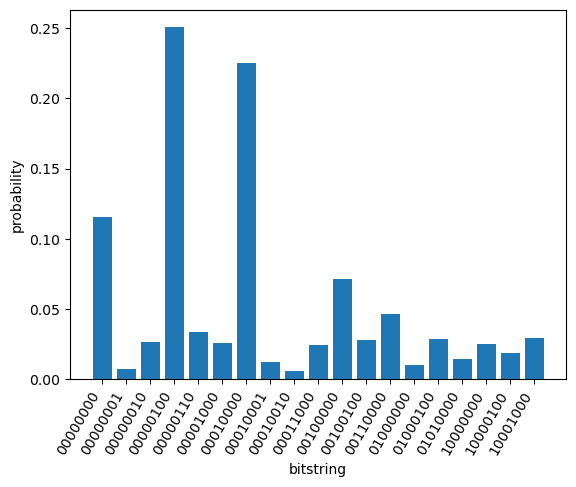

In [19]:
# The most probable bitstrings are:

bitstring_hist(reg1; nlargest = 20)

In [20]:
# We see that, without optimization, many of these bitstrings are not the MIS solutions.

# Let us now use the non-gradient-based optimizer `NelderMead` in the `Optim` package to optimize the loss function:
optresult = Optim.optimize(x -> loss_piecewise_constant(atoms, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atoms, optresult.minimizer)
rydberg_density_final

-1.8979142287572017

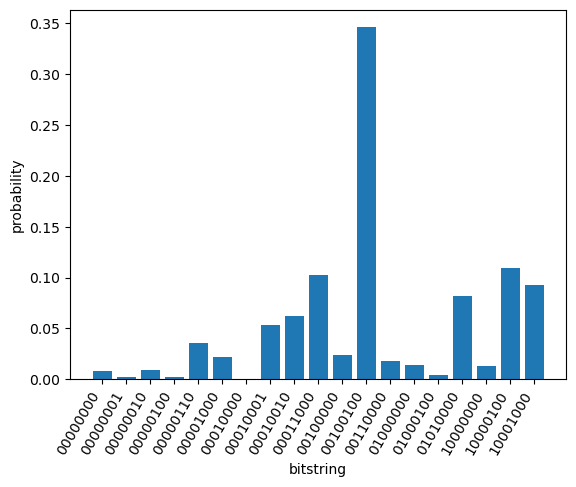

In [21]:
# We see that the loss is indeed improved, but still not very good.
# This is likely because the optimization is trapped in a local minimum.

bitstring_hist(reg1_final; nlargest = 20)

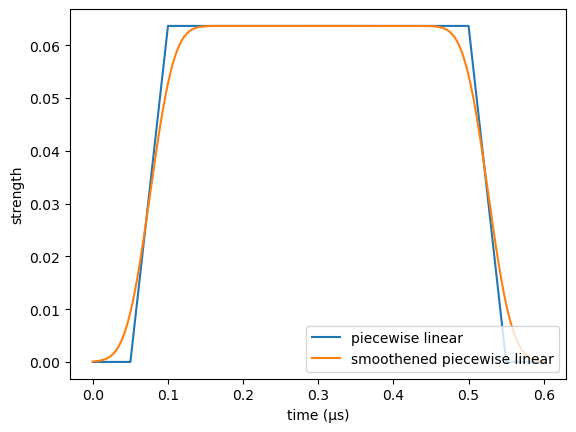

In [22]:
# This example shows that the performance of the algorithm very much depends on 
# the parametrization of the pulse sequences, the initialization of the variational parameters, 
# and the classical optimizers. 
# See [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372)
# for more in-depth comparison of different pulse parametrizations and tips on how to improve the performance.

# In the example below, we show a better pulse parametrization 
# using smoothened piecewise linear waveforms. 

# ## Smoothened Piecewise Linear Pulses

# A smoothened piecewise linear waveform can be created by applying a Gaussian filter on a waveform created by the `piecewise_linear` function. 
# For example:
pulse_piecewise_linear = piecewise_linear(clocks = [0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = [0, 0, 0.4, 0.4, 0, 0]);
pulse_smooth = smooth(pulse_piecewise_linear; kernel_radius = 0.02);

fig, ax = plt.subplots()
Bloqade.plot!(ax, pulse_piecewise_linear)
Bloqade.plot!(ax, pulse_smooth)
ax.set_ylabel("strength")
ax.legend(["piecewise linear", "smoothened piecewise linear"], loc = "lower right")
fig

In [23]:
# Here, the function [`smooth`](@ref) takes a `kernel_radius` keyword parameter as the Gaussian kernel parameter.
# With the new waveforms, we can define the loss function as follows:

function loss_piecewise_linear(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) == 3
    Ω_max = 4 * 2π
    Δ_start = -13 * 2π
    Δ_end = 11 * 2π
    Δ0 = 11 * 2π
    T_max = 0.6

    ## the strength of the detunings at each step takes the optimizing x as their input 
    Δs = smooth(
        piecewise_linear(
            clocks = T[0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
            values = T[Δ_start, Δ_start, Δ0*x[1], Δ0*x[2], Δ0*x[3], Δ_end, Δ_end],
        );
        kernel_radius = 0.02,
    )
    Ωs = smooth(
        piecewise_linear(clocks = T[0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = T[0, 0, Ω_max, Ω_max, 0, 0]);
        kernel_radius = 0.02,
    )

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)
    prob = SchrodingerProblem(zero_state(Complex{T}, subspace), T_max, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg, Δs
end

x0 = [0.1, 0.8, 0.8]; # initial point for the optimization

In [24]:
# Let us check the loss function with smoothened waveform with the initial point:
Δ_start = -13 * 2π
Δ_end = 11 * 2π
Δ0 = 11 * 2π
T_max = 0.6
Δ_initial = piecewise_linear(
    clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
    values = [Δ_start, Δ_start, Δ0 * x0[1], Δ0 * x0[2], Δ0 * x0[3], Δ_end, Δ_end],
)

rydberg_density, reg2, Δ_initial_smooth = loss_piecewise_linear(atoms, x0)
rydberg_density

-1.9389723362475466

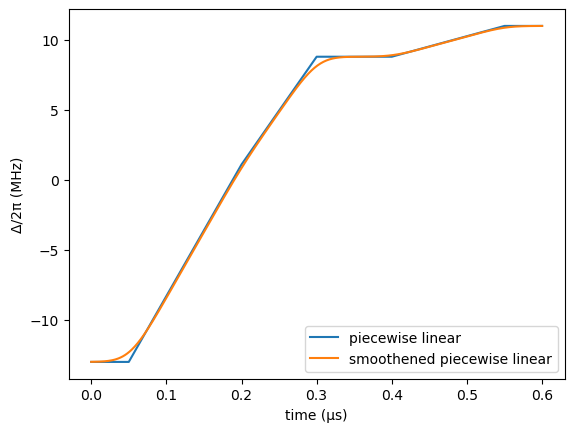

In [25]:
# And plot the smoothened waveform:
fig, ax = plt.subplots()
Bloqade.plot!(ax, Δ_initial)
Bloqade.plot!(ax, Δ_initial_smooth)
ax.set_ylabel("Δ/2π (MHz)")
ax.legend(["piecewise linear", "smoothened piecewise linear"], loc = "lower right")
fig

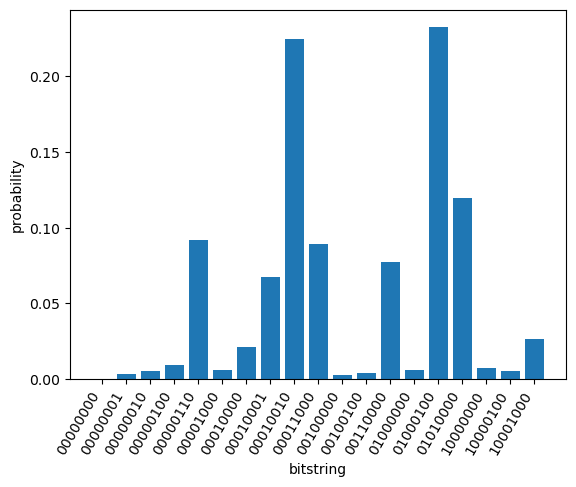

In [26]:
# Let's plot the distribution:
bitstring_hist(reg2; nlargest = 20)

In [27]:
# The performance of the algorithm is quite good. 
# Again, let us use the `NelderMead` optimizer to optimize the loss function:
optresult = Optim.optimize(x -> loss_piecewise_linear(atoms, x)[1], x0)

rydberg_density_final, reg_final, Δ_final = loss_piecewise_linear(atoms, optresult.minimizer)
rydberg_density_final

-1.9948148206289085

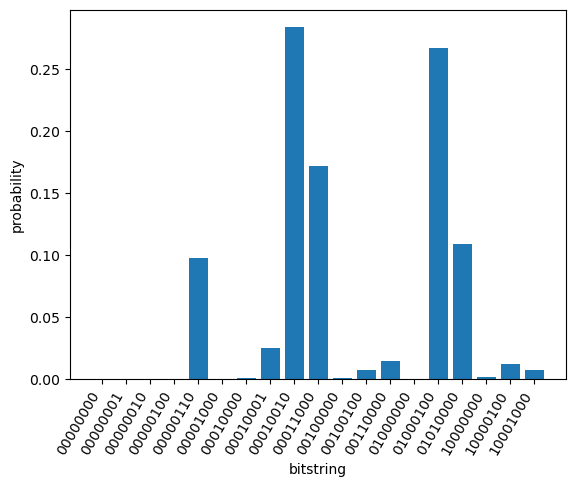

In [28]:
# One can see the mean MIS size can be further improved to a value close to the size of the MIS,
# which means there is a substantial probability for measuring an MIS state. 

bitstring_hist(reg_final; nlargest = 20)

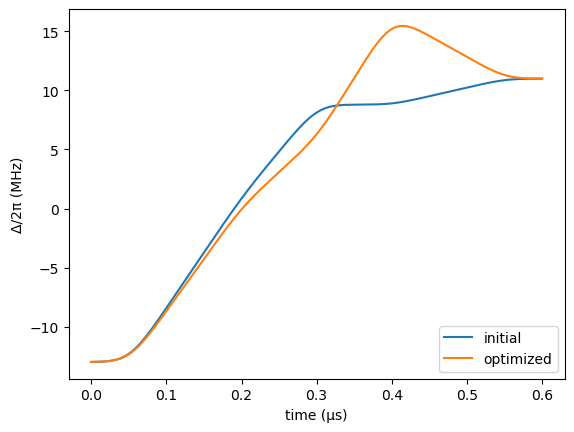

In [29]:
# We can also plot out the final optimized waveform for Δ 
# and compare with the initial waveform:
fig, ax = plt.subplots()
Bloqade.plot!(ax, Δ_initial_smooth)
Bloqade.plot!(ax, Δ_final)
ax.set_ylabel("Δ/2π (MHz)")
ax.legend(["initial", "optimized"], loc = "lower right")
fig